# Notebook to learn about PySM and how to generate maps with modified parameters

In [2]:
import pysm3
import pysm3.units as u
from pysm3 import models
import healpy as hp
import numpy as np
import toml

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Dust Model

In [4]:
# yaml file - /bigdata/aankit/cmb-ml/cmbml/cfg/model/sim/sim_flex_fgs.yaml

nside = 2048
freq = 545
sky = pysm3.Sky(nside=nside, preset_strings=["d4"]) 
map_dust_default = sky.get_emission(freq * u.GHz)  


/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


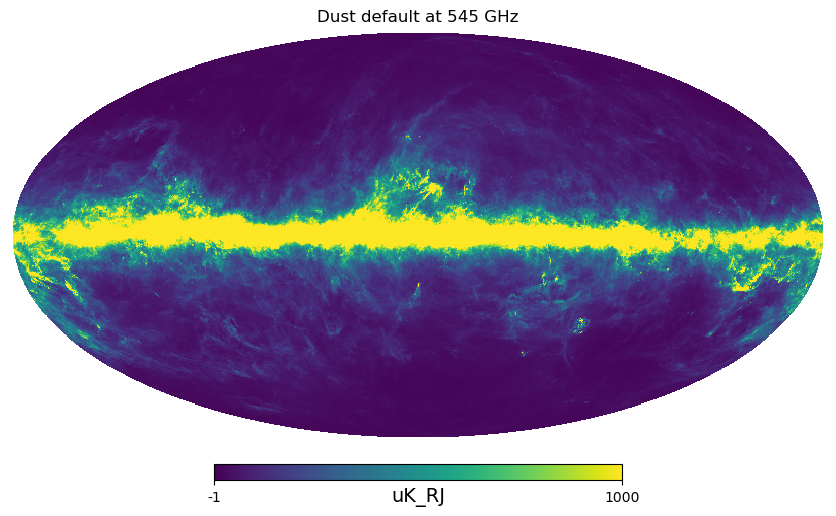

In [5]:
hp.mollview(map_dust_default[0], 
            title=f"Dust default at {freq} GHz", 
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
plt.show()



<Figure size 640x480 with 0 Axes>

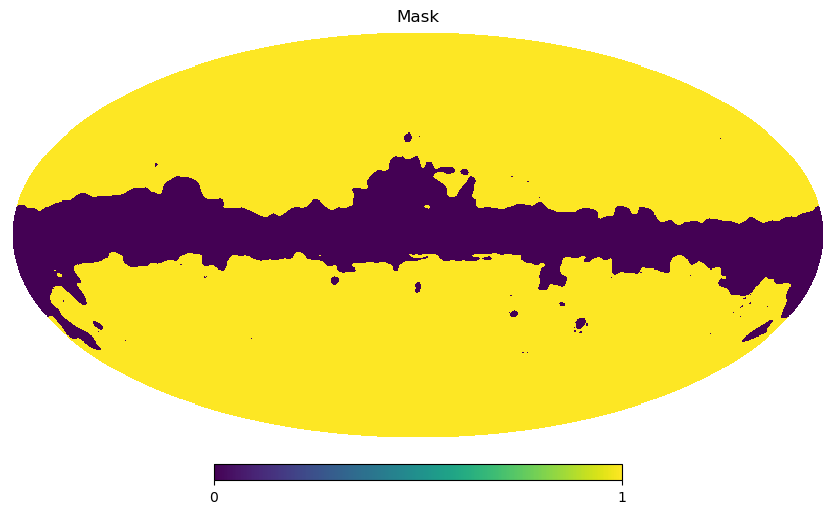

In [6]:
nilc_mask_fn = "/bigdata/cmb_project/data/Assets/Planck/COM_CMB_IQU-nilc_2048_R3.00_full.fits"
mask = hp.read_map(nilc_mask_fn, field=3) #field 3 for temp, 4 for polarization
plt.figure(dpi=100)
hp.mollview(mask, title="Mask")

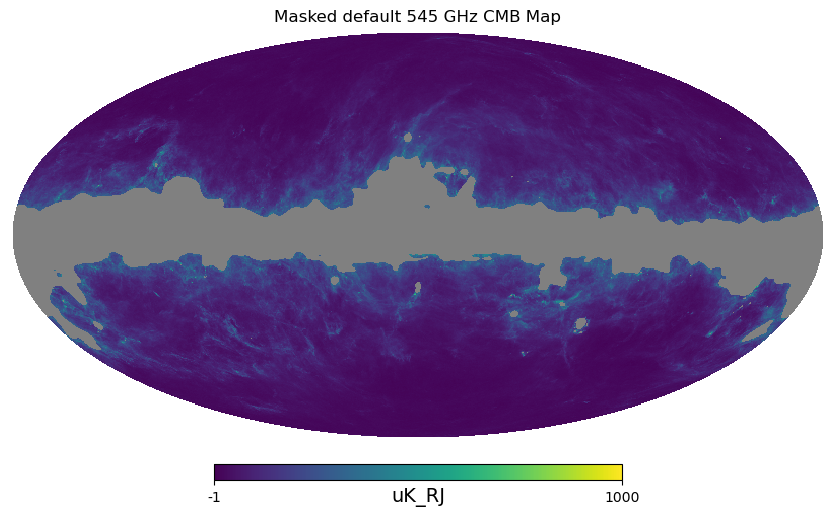

In [7]:
map_dust_default_map = hp.ma(map_dust_default[0])
map_dust_default_map.mask = np.logical_not(mask)

hp.mollview(map_dust_default_map, title=f"Masked default {freq} GHz CMB Map", unit=map_dust_default.unit, min = -1, max = 1000)

In [8]:
def get_masked_map(sky_map, mask):
    sky_map_masked = hp.ma(sky_map[0])
    sky_map_masked.mask = np.logical_not(mask)
    return sky_map_masked

## Modified Dust

In [9]:
nside = 2048
# 10% plus minus of 1.48 is 1.628 & 1.332 and 19.6 is 17.64 & 21.56
dust_component1 = models.ModifiedBlackBody(
    nside=nside,
    map_I=f"dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index=1.332, # 10% lower bound
    map_mbb_temperature=19.6, #default
    unit_mbb_temperature="K",
    freq_ref_I="353 GHz",
    freq_ref_P="353 GHz"
)

dust_component2 = models.ModifiedBlackBody(
    nside=nside,
    map_I=f"dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index=1.628, # 10% upper bound
    map_mbb_temperature=19.6, #default
    unit_mbb_temperature="K",
    freq_ref_I="353 GHz",
    freq_ref_P="353 GHz"
)

dust_component3 = models.ModifiedBlackBody(
    nside=nside,
    map_I=f"dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index=1.48, # default
    map_mbb_temperature=17.64,  # 10% lower bound
    unit_mbb_temperature="K",
    freq_ref_I="353 GHz",
    freq_ref_P="353 GHz"
)

dust_component4 = models.ModifiedBlackBody(
    nside=nside,
    map_I=f"dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index=1.48, # default 
    map_mbb_temperature=21.56,  # 10% upper bound
    unit_mbb_temperature="K",
    freq_ref_I="353 GHz",
    freq_ref_P="353 GHz"
)


: 

In [ ]:
sky1 = pysm3.Sky(nside=nside, component_objects=[dust_component1])
sky2 = pysm3.Sky(nside=nside, component_objects=[dust_component2])
sky3 = pysm3.Sky(nside=nside, component_objects=[dust_component3])
sky4 = pysm3.Sky(nside=nside, component_objects=[dust_component4])

sky_map_param1_unmasked = sky1.get_emission(freq * u.GHz)  
sky_map_param1 = get_masked_map(sky_map_param1_unmasked, mask)
sky_map_param2_unmasked = sky2.get_emission(freq * u.GHz)
sky_map_param2 = get_masked_map(sky_map_param2_unmasked, mask)
sky_map_param3_unmasked = sky3.get_emission(freq * u.GHz) 
sky_map_param3 = get_masked_map(sky_map_param3_unmasked, mask)
sky_map_param4_unmasked = sky4.get_emission(freq * u.GHz) 
sky_map_param4 = get_masked_map(sky_map_param4_unmasked, mask) 


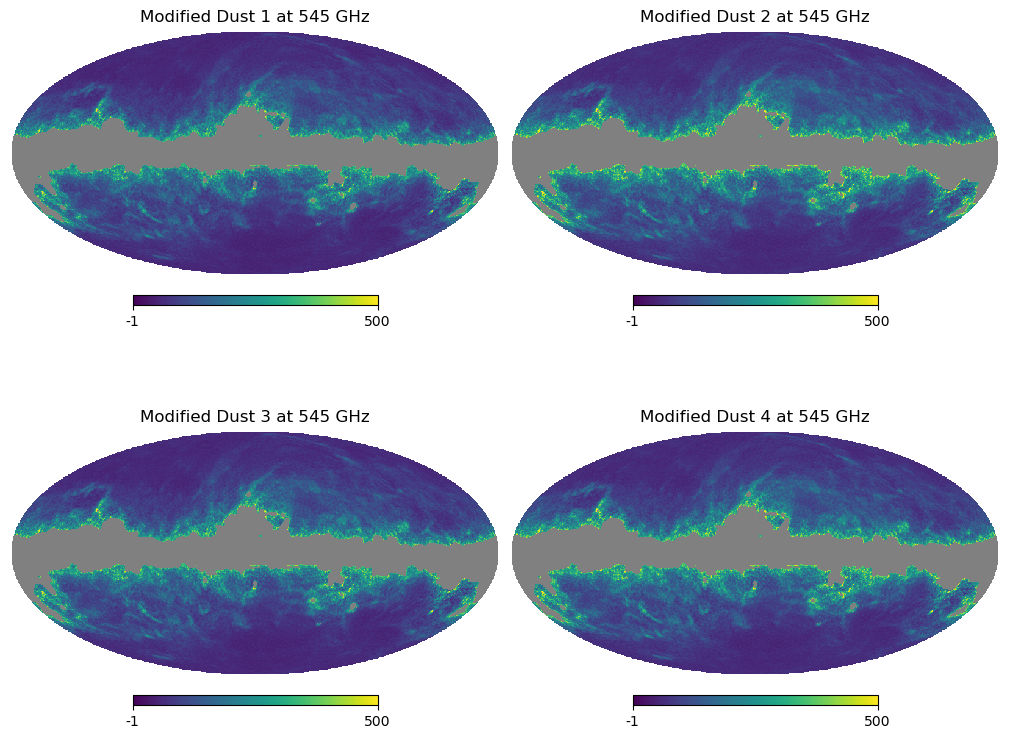

In [ ]:
plt.figure(figsize=(10, 8))

hp.mollview(sky_map_param1, sub=(2,2,1), title=f"Modified Dust 1 at {freq} GHz", min = -1, max = 500)
hp.mollview(sky_map_param2, sub=(2,2,2), title=f"Modified Dust 2 at {freq} GHz", min = -1, max = 500)
hp.mollview(sky_map_param3, sub=(2,2,3), title=f"Modified Dust 3 at {freq} GHz", min = -1, max = 500)
hp.mollview(sky_map_param4, sub=(2,2,4), title=f"Modified Dust 4 at {freq} GHz", min = -1, max = 500)


plt.show()

## Difference of the maps

In [ ]:
print(type(sky_map_param1), type(map_dust_default))

<class 'numpy.ma.core.MaskedArray'> <class 'astropy.units.quantity.Quantity'>


In [ ]:
percentile=90
difference1 = map_dust_default_map - sky_map_param1
v1 = np.percentile(np.abs(difference1), percentile)
difference2 = map_dust_default_map - sky_map_param2
v2 = np.percentile(np.abs(difference2), percentile)
difference3 = map_dust_default_map - sky_map_param3
v3 = np.percentile(np.abs(difference3), percentile)
difference4 = map_dust_default_map - sky_map_param4
v4 = np.percentile(np.abs(difference4), percentile)

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [ ]:
print(f"v1: {v1}, v2: {v2}, v3: {v3}, v4: {v4}")
print(difference1, difference2, difference3.shape, difference4.shape)

v1: 710.8718872070312, v2: 710.8718872070312, v3: 710.8718872070312, v4: 710.8718872070312
[-31.888874452339152 -31.873590436994398 -33.02999760387302 ...
 -30.944162946779713 -29.09476724013407 -31.589811382474984] [-38.179599760155185 -38.044117654926914 -39.30888827529267 ...
 -37.770173555313654 -35.81947401183594 -38.36860368736616] (50331648,) (50331648,)


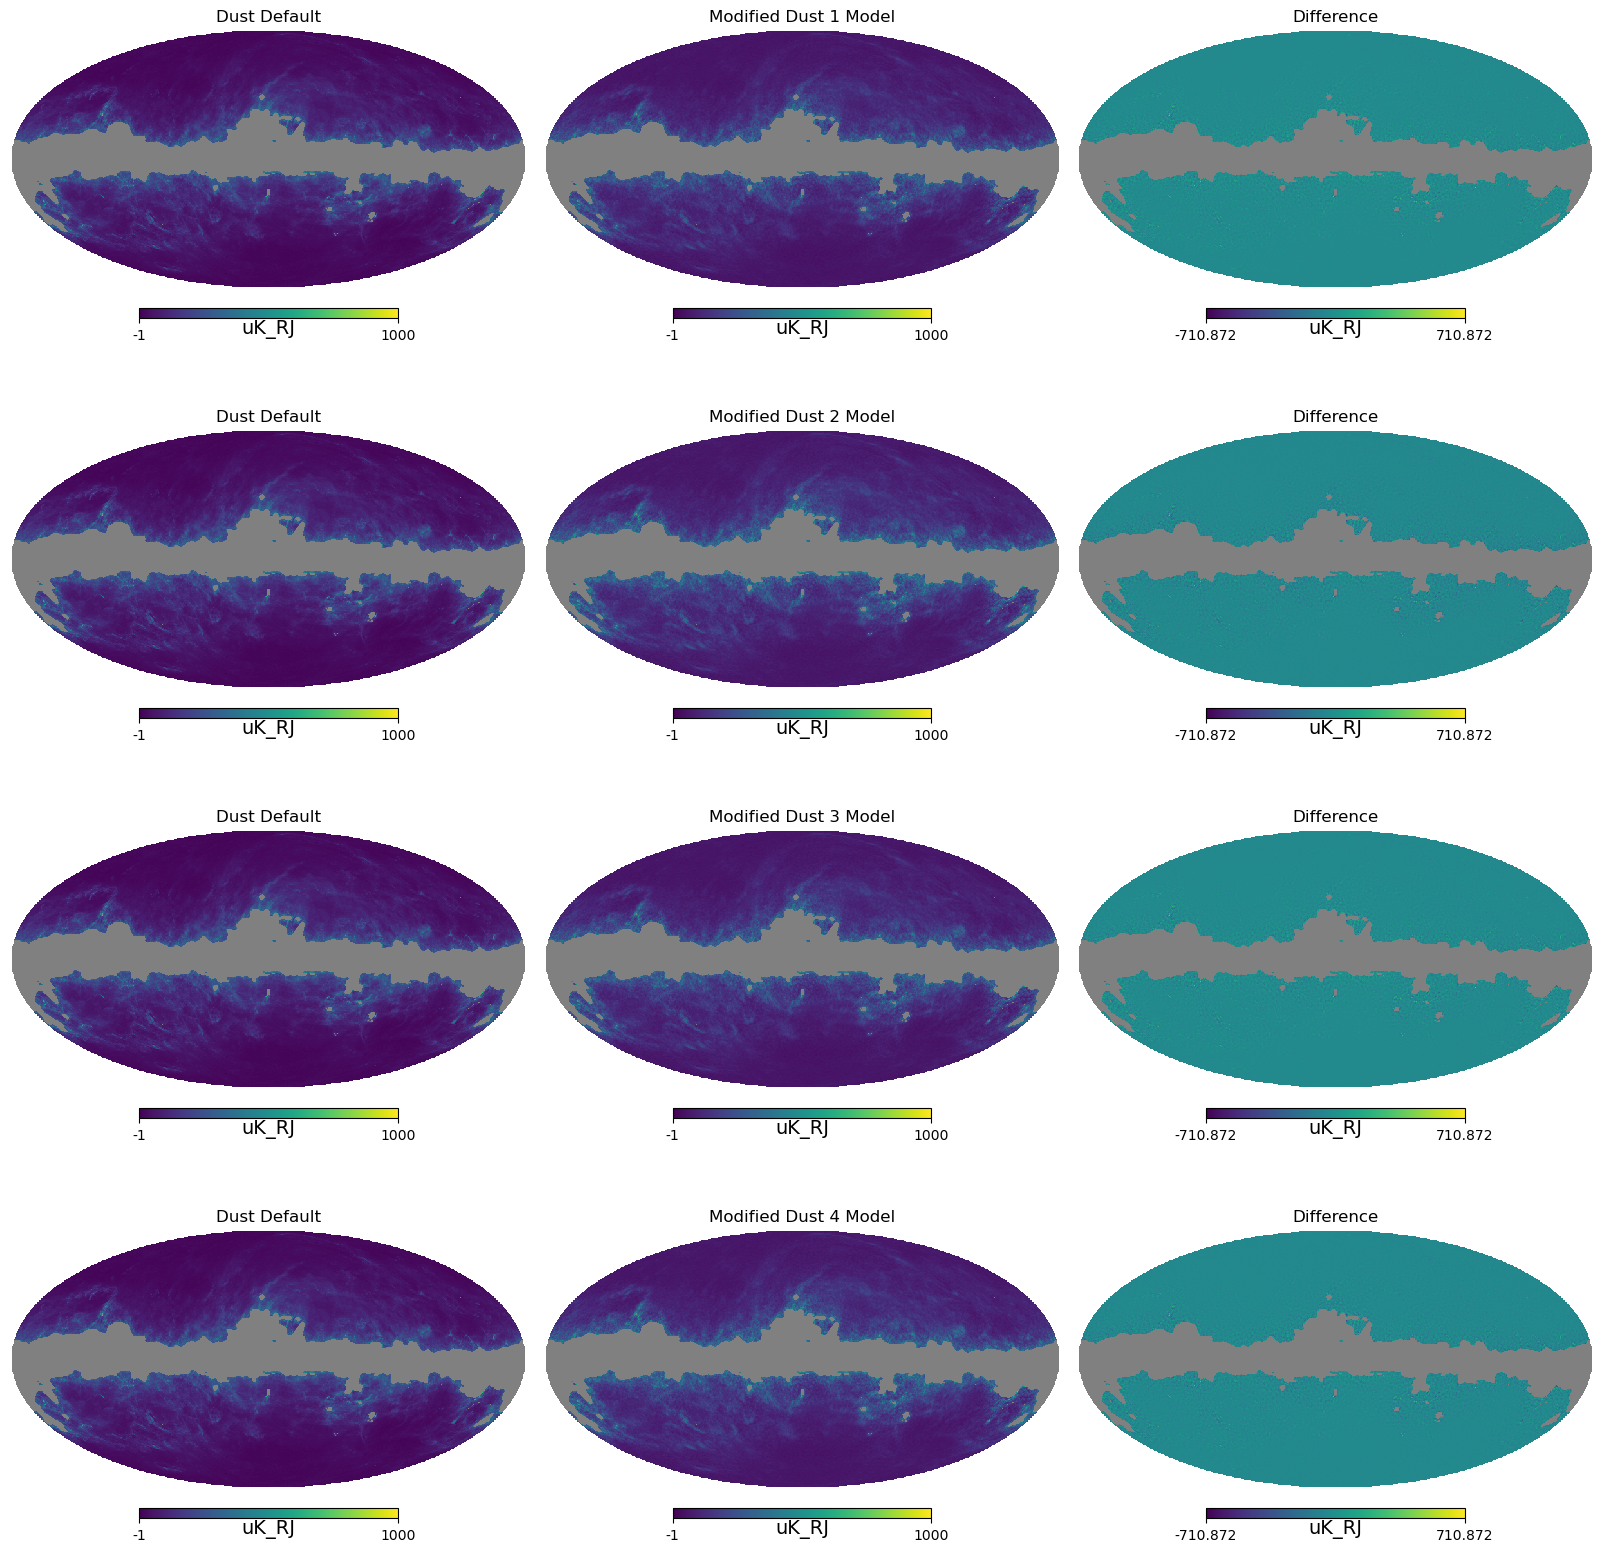

In [ ]:

plt.figure(figsize=(16, 16))
#Dust1
hp.mollview(map_dust_default_map, 
            title="Dust Default", 
            sub=(4, 3, 1),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(sky_map_param1, 
            title="Modified Dust 1 Model", 
            sub=(4, 3, 2),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(difference1, 
            title="Difference", 
            sub=(4, 3, 3),
            unit=map_dust_default.unit, 
            min = -v1, 
            max = v1)
#Dust2
hp.mollview(map_dust_default_map, 
            title="Dust Default", 
            sub=(4, 3, 4),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(sky_map_param2, 
            title="Modified Dust 2 Model", 
            sub=(4, 3, 5),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(difference2, 
            title="Difference", 
            sub=(4, 3, 6),
            unit=map_dust_default.unit, 
            min = -v2, 
            max = v2)
#Dust3
hp.mollview(map_dust_default_map, 
            title="Dust Default", 
            sub=(4, 3, 7),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(sky_map_param3, 
            title="Modified Dust 3 Model", 
            sub=(4, 3, 8),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(difference3, 
            title="Difference", 
            sub=(4, 3, 9),
            unit=map_dust_default.unit, 
            min = -v3, 
            max = v3)
#Dust4
hp.mollview(map_dust_default_map, 
            title="Dust Default", 
            sub=(4, 3, 10),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(sky_map_param4, 
            title="Modified Dust 4 Model", 
            sub=(4, 3, 11),
            unit=map_dust_default.unit, 
            min = -1, 
            max = 1000)
hp.mollview(difference4, 
            title="Difference", 
            sub=(4, 3, 12),
            unit=map_dust_default.unit, 
            min = -v4, 
            max = v4)

plt.show()

In [ ]:
m1 = map_dust_default_map.flatten()
m2 = sky_map_param1.flatten()
diff = m1 - m2

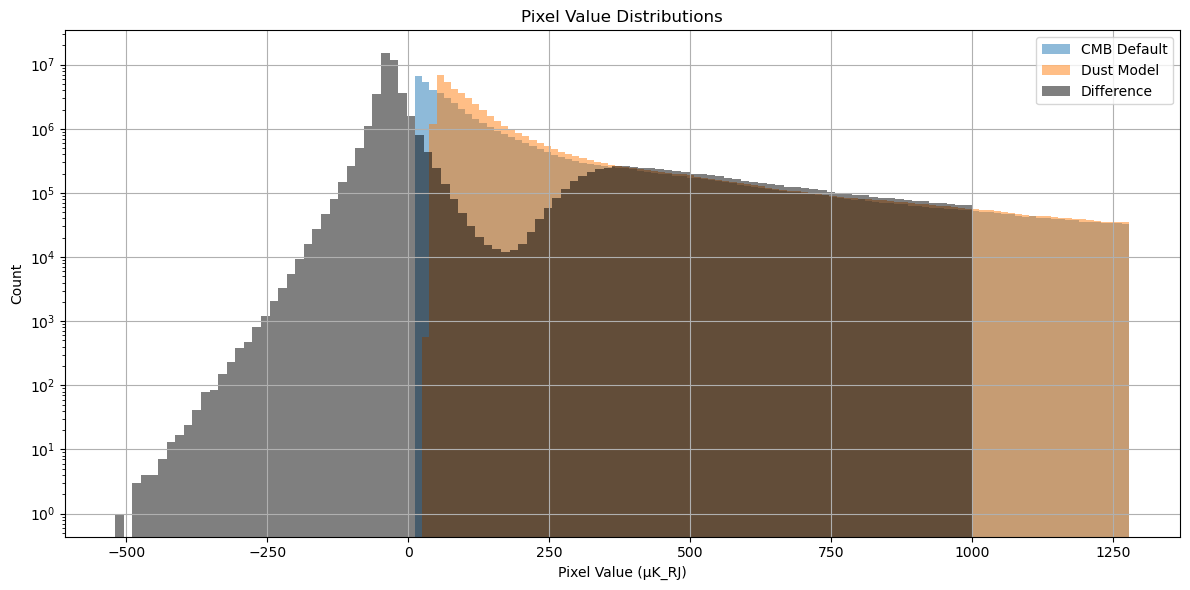

In [ ]:
#only taking middle 99% of the pixel values for better visualization
vmin, vmax = np.percentile(m1, [0.5, 95])

plt.figure(figsize=(12, 6))

#turn these on or off to see the difference
plt.hist(m1, bins=100, alpha=0.5, label="CMB Default", range=(vmin, vmax), log=True) 
plt.hist(m2, bins=100, alpha=0.5, label="Dust Model", range=(vmin, vmax), log=True)
plt.hist(diff, bins=100, alpha=0.5, label="Difference", color='black', log=True)

plt.xlabel("Pixel Value (μK_RJ)")
plt.ylabel("Count")
plt.title("Pixel Value Distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# statistical tests
print("Mean difference:", np.mean(diff))
print("Std deviation of difference:", np.std(diff))

Mean difference: -31.73820026318679
Std deviation of difference: 26.47644153344516
Paired t-test p-value: 0.0
KS test p-value: 0.0
Mann-Whitney U test p-value: 0.0


In [ ]:
mean_temp_default = np.mean(map_dust_default_map.flatten())
mean_temp_1 = np.mean(sky_map_param1)

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


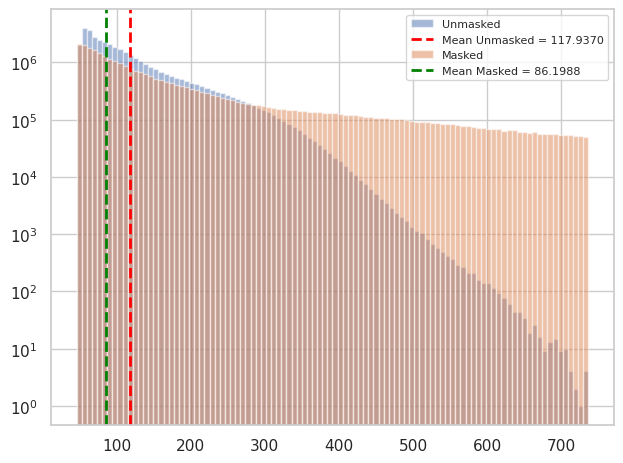

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
vmin, vmax = np.percentile(sky_map_param1, [0.5, 90])
plt.hist(sky_map_param1.compressed(), bins=100, alpha=0.5, label="Unmasked", range=(vmin, vmax), log=True)
plt.axvline(mean_temp_1, color='red', linestyle='dashed', linewidth=2, label=f"Mean Unmasked = {mean_temp_1:.4f}")

plt.hist(map_dust_default_map, bins=100, alpha=0.5, label="Masked", range=(vmin, vmax), log=True)
plt.axvline(mean_temp_default, color='green', linestyle='dashed', linewidth=2, label=f"Mean Masked = {mean_temp_default:.4f}")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

## Modified Free-Free

In [ ]:
nside = 2048
freq = 150
sky = pysm3.Sky(nside=nside, preset_strings=["f1"])


In [ ]:
map_ff_default = sky.get_emission(freq * u.GHz)  # Simulate at 150 GHz

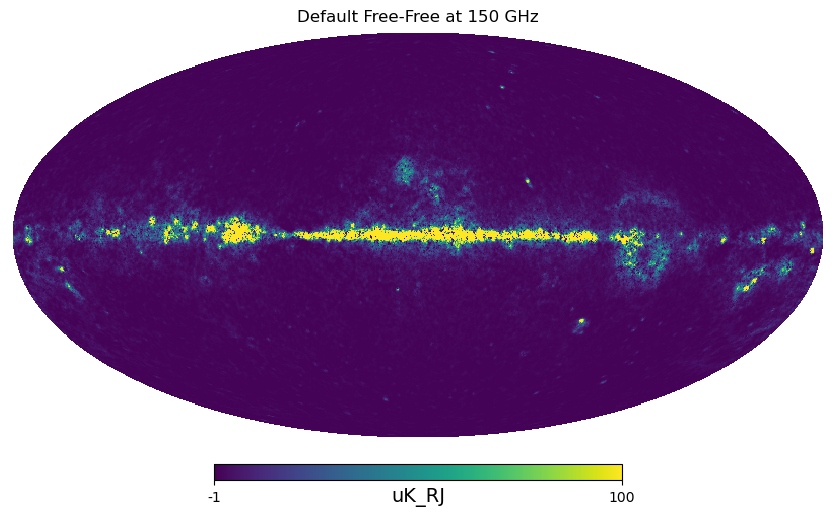

In [ ]:
hp.mollview(map_ff_default[0], title=f"Default Free-Free at {freq} GHz", unit=map_ff_default.unit, min = -1, max = 100)
plt.show()

In [ ]:
# 10% of -2.14 plus or minus gives -2.14 +/- 0.214 = -1.926 to -2.354
ff_preset_string1 = """
[f1]
class= "PowerLaw"
map_I= "pysm_2/ff_t_new.fits"
unit_I= "uK_RJ"
map_pl_index= -1.926
freq_ref_I= "30 GHz"
has_polarization= false
"""
ff_preset_string2 = """
[f1]
class= "PowerLaw"
map_I= "pysm_2/ff_t_new.fits"
unit_I= "uK_RJ"
map_pl_index= -2.354
freq_ref_I= "30 GHz"
has_polarization= false
"""

In [ ]:
ff_toml1 = {"ff": toml.loads(ff_preset_string1)}
ff_toml2 = {"ff": toml.loads(ff_preset_string2)}

In [ ]:
ff_sky1 = pysm3.sky.create_components_from_config(ff_toml1, nside=nside, map_dist=None)
ff_sky2 = pysm3.sky.create_components_from_config(ff_toml2, nside=nside, map_dist=None)

In [ ]:
map_ff_param1 = ff_sky1[0].get_emission(freq * u.GHz)
map_ff_param2 = ff_sky2[0].get_emission(freq * u.GHz)


<Figure size 1000x800 with 0 Axes>

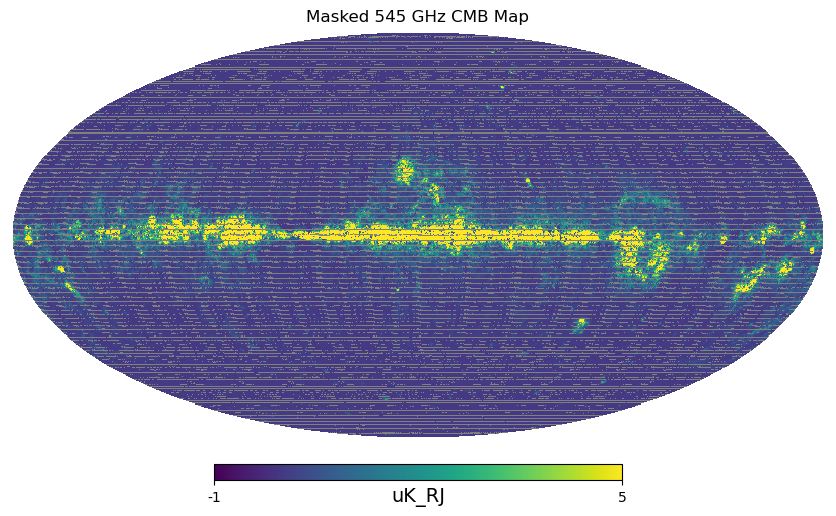

<Figure size 1000x800 with 0 Axes>

: 

In [ ]:
map_ff_param1_map = hp.ma(map_ff_param1[0])
map_ff_param1_map.mask = np.logical_not(mask)

hp.mollview(map_ff_param1_map, title=f"Masked {freq} GHz CMB Map", unit=map_ff_param1.unit, min = -1, max = 5)

plt.figure(figsize=(10, 8))

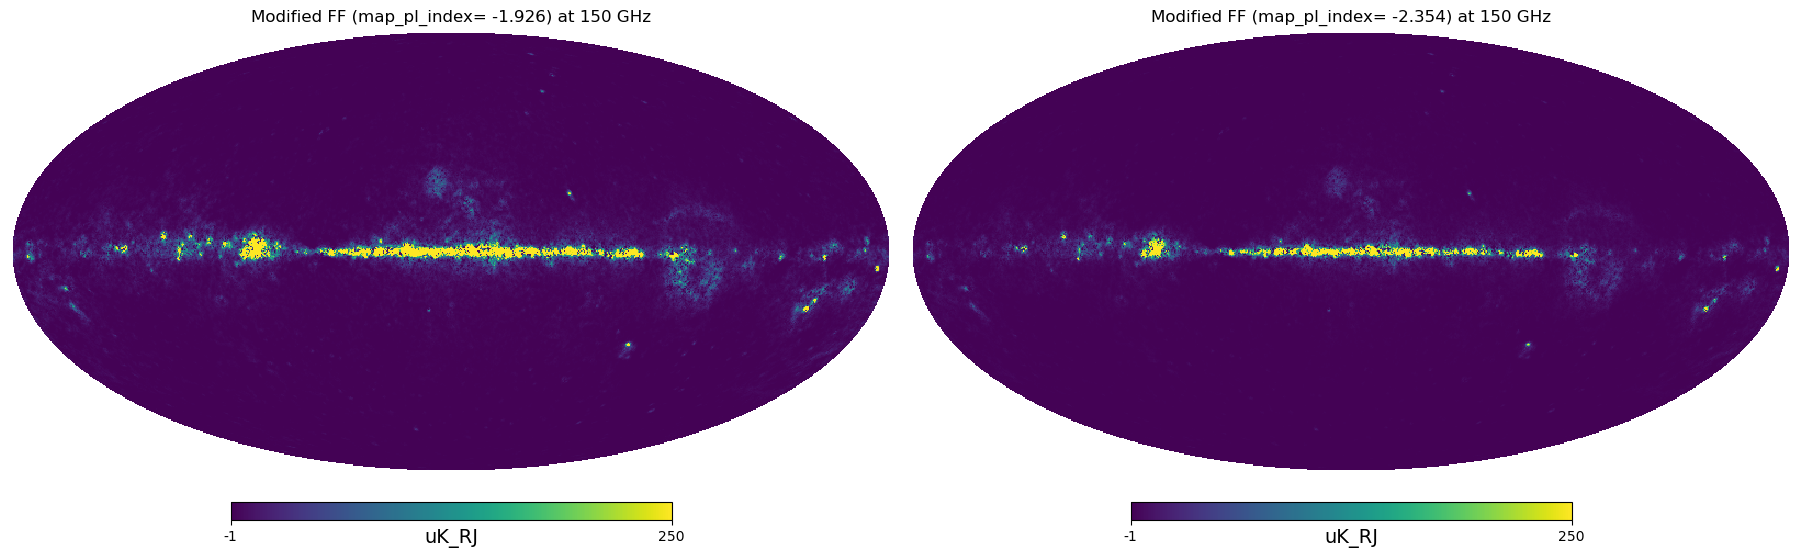

In [ ]:
plt.figure(figsize=(18, 6))
hp.mollview(map_ff_param1[0],sub=(1,2,1), title=f"Modified FF (map_pl_index= -1.926) at {freq} GHz", unit=map_ff_param1.unit, min = -1, max = 250)
hp.mollview(map_ff_param2[0],sub=(1,2,2), title=f"Modified FF (map_pl_index= -2.354) at {freq} GHz", unit=map_ff_param2.unit, min = -1, max = 250)

plt.show()

## Difference

In [ ]:
difference1 = map_ff_default[0] - map_ff_param1[0]
v1 = np.percentile(np.abs((difference1).value), 99)
difference2 = map_ff_default[0] - map_ff_param2[0]
v2 = np.percentile(np.abs((difference2).value), 99)

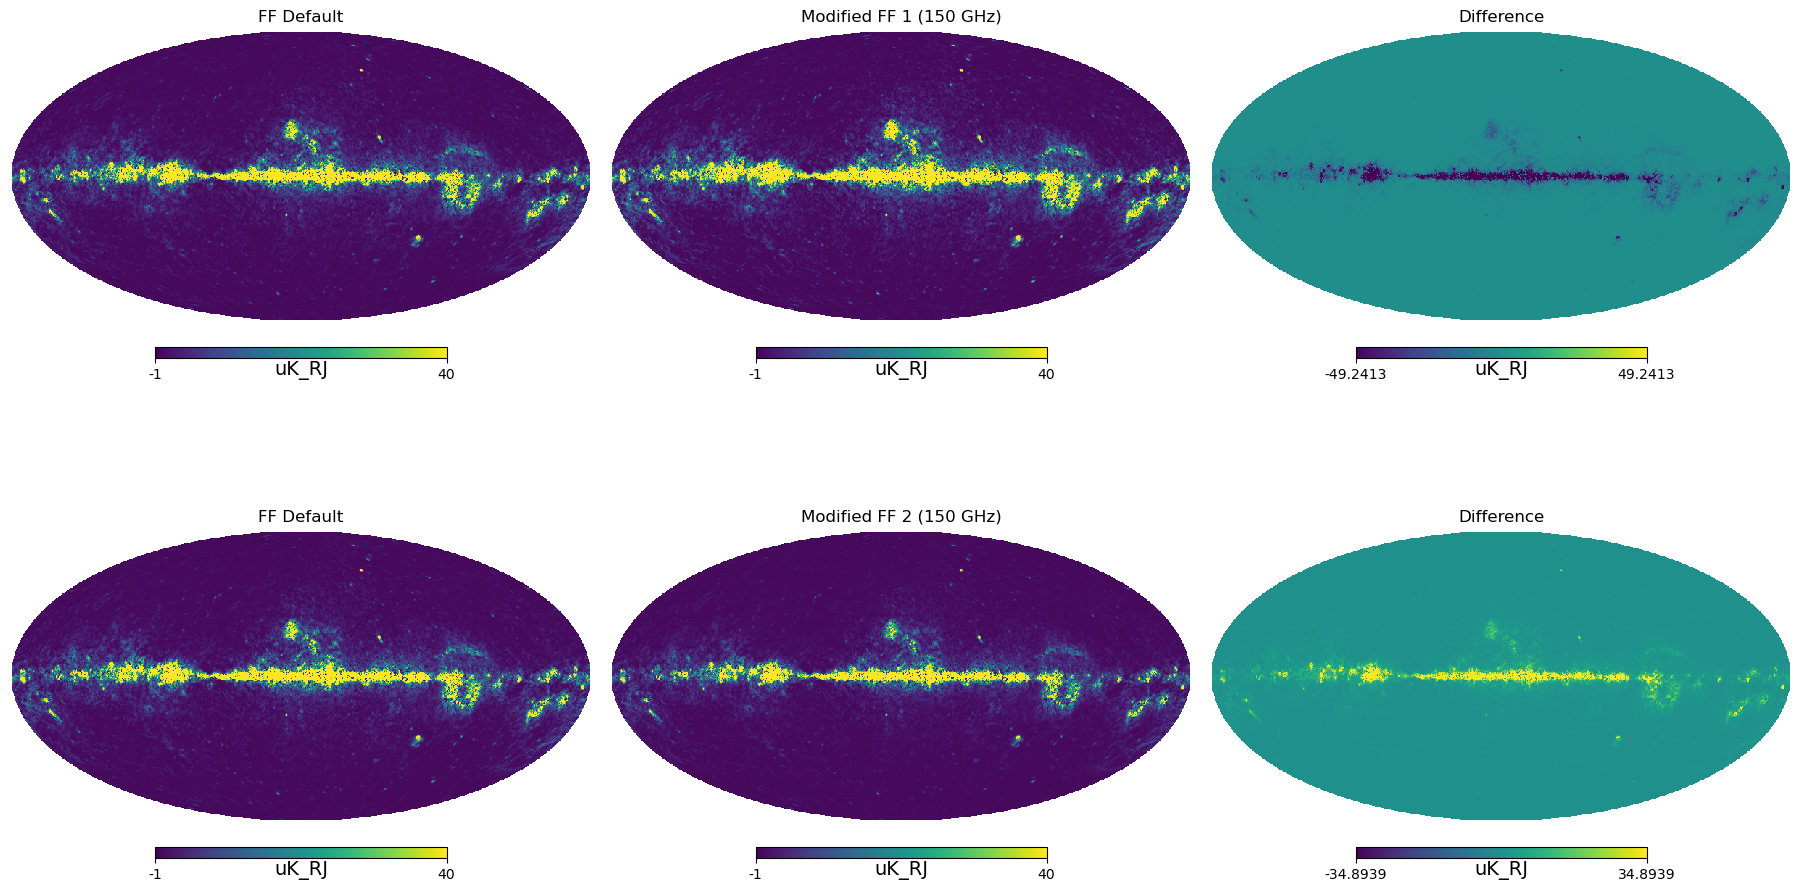

In [ ]:

plt.figure(figsize=(18, 10))
# modified FF 1
hp.mollview(map_ff_default[0], 
            title="FF Default", 
            sub=(2, 3, 1),
            unit=map_ff_param1.unit, 
            min = -1, 
            max = 40)
hp.mollview(map_ff_param1[0], 
            title=f"Modified FF 1 ({freq} GHz)", 
            sub=(2, 3, 2),
            unit=map_ff_param1.unit, 
            min = -1, 
            max = 40)

hp.mollview(difference1, 
            title="Difference", 
            sub=(2, 3, 3),
            unit=map_ff_param1.unit, 
            min = -v1, 
            max = v1)

#modified FF 2
hp.mollview(map_ff_default[0], 
            title="FF Default", 
            sub=(2, 3, 4),
            unit=map_ff_param2.unit, 
            min = -1, 
            max = 40)
hp.mollview(map_ff_param2[0], 
            title=f"Modified FF 2 ({freq} GHz)" , 
            sub=(2, 3, 5),
            unit=map_ff_param2.unit, 
            min = -1, 
            max = 40)
hp.mollview(difference2, 
            title="Difference", 
            sub=(2, 3, 6),
            unit=map_ff_param2.unit, 
            min = -v2, 
            max = v2)
plt.show()

In [ ]:
m1 = map_ff_default[0].value.flatten()
m2 = map_ff_param1[0].value.flatten()
diff = m1 - m2

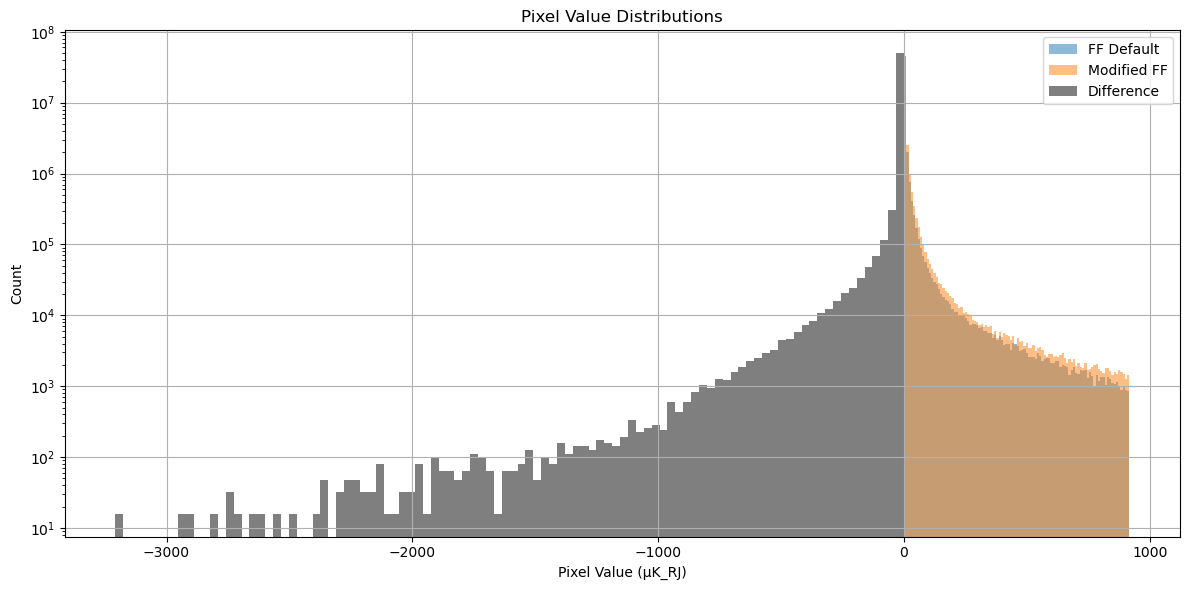

In [ ]:
#only taking middle 99% of the pixel values for better visualization
vmin, vmax = np.percentile(m1, [0.5, 99.9])

plt.figure(figsize=(12, 6))

#turn these on or off to see the difference
plt.hist(m1, bins=100, alpha=0.5, label="FF Default", range=(vmin, vmax), log=True) 
plt.hist(m2, bins=100, alpha=0.5, label="Modified FF", range=(vmin, vmax), log=True)
plt.hist(diff, bins=100, alpha=0.5, label="Difference", color='black', log=True)

plt.xlabel("Pixel Value (μK_RJ)")
plt.ylabel("Count")
plt.title("Pixel Value Distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# statistical tests
from scipy.stats import ttest_rel, mannwhitneyu, ks_2samp

print("Mean difference:", np.mean(diff))
print("Std deviation of difference:", np.std(diff))

t_stat, t_p = ttest_rel(m1, m2)
print("Paired t-test p-value:", t_p)

ks_stat, ks_p = ks_2samp(m1, m2)
print("KS test p-value:", ks_p)

u_stat, u_p = mannwhitneyu(m1, m2, alternative='two-sided')
print("Mann-Whitney U test p-value:", u_p)


Mean difference: -3.126776984025511
Std deviation of difference: 26.767161496893365
Paired t-test p-value: 0.0
KS test p-value: 0.0
Mann-Whitney U test p-value: 0.0


## Synchrotron

In [ ]:
nside = 2048
freq = 545
sky = pysm3.Sky(nside=nside, preset_strings=["s4"]) 
map_dust_default = sky.get_emission(freq * u.GHz)  

/bigdata/aankit/miniconda/envs/cmb-ml-py-312/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
# 10% of -3.1 plus or minus gives -2.79 to -3.41
ff_preset_string1 = """
[s4]
class= "PowerLaw"
map_I= "synch/synch_template_nside2048_2023.02.25.fits"
map_pl_index: -2.79
freq_ref_I: "23 GHz"
freq_ref_P: "23 GHz"
max_nside: 8192
available_nside: [2048, 4096, 8192]
has_polarization: false
"""
ff_preset_string2 = """
[f1]
class= "PowerLaw"
map_I= "synch/synch_template_nside2048_2023.02.25.fits"
map_pl_index: -3.41
freq_ref_I: "23 GHz"
freq_ref_P: "23 GHz"
max_nside: 8192
available_nside: [2048, 4096, 8192]
has_polarization: false
"""